# Example use of implemented conductance models

Figure 3 in Code paper

Using implemented [Hardy et al. (1987)](https://doi.org/10.1029/JA092iA11p12275) for auroral contribution to conductances.
Using implementation of a novel method to calculate the solar extreme ultraviolet (EUV) contribution to the ionospheric conductance (the method is described in Section 2.4 in [Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)). 

Import relevant modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import lompe
from lompe.utils.conductance import *

Re = 6371.2e3    # Earth radius

We set up cubed sphere grid (over large portion of high-latitude northern hemisphere) to get the conductances for. Note that any coordinates could be used:

In [2]:
Lres, Wres = 50e3, 50e3
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0) # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, 20000e3, 20000e3, Lres, Wres, R = Re+110e3) # set to ionospheric altitude

Plot the grid:

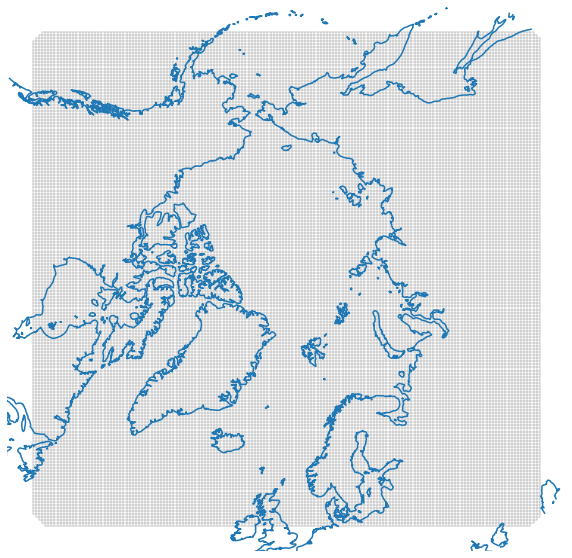

In [3]:
# plot grid and coastlines
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim);

Get conductances on grid:

In [4]:
time = dt.datetime(2014, 3, 10, 12, 30) # used for coordinate conversion and to get solar zenith angles (sza)
Kp   = 4 # for Hardy model
F107 = 100 # sfu, for EUV conductance
refh = 110 # km, for coodinate conversion

# get the 
SH, SP = hardy_EUV(grid.lon, grid.lat, Kp, time, 'hp', F107, refh = refh)

The method can also return only the Hall, or only the Pedersen conductance by specifying *hall_or_pedersen* to '*hall*' or '*pedersen*' only. An additional input parameter of *calibration* can be given, which is relevant for how the EUV contribution to the conductances is calculated (see the last heading in this notebook).

## Polplot

We illustrate how the ionospheric conductances look on the nortern hemisphere using polplot.

    # TODO: MORE HERE 

This is a class which handles plotting in polar coordinates, specifically an MLT/MLAT grid or similar.

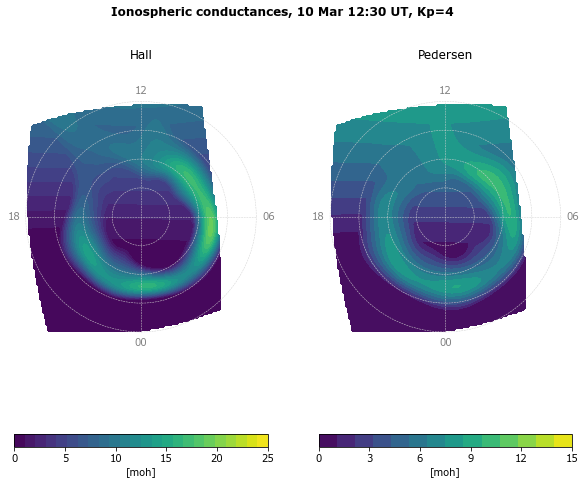

In [5]:
# get magnetic coordinates
a = Apex(time, refh)
mlat, mlon = a.geo2apex(grid.lat, grid.lon, refh)
mlt = a.mlon2mlt(mlon, time)

fig = plt.figure(figsize = (10,8))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax1.set_title('Hall')
ax2.set_title('Pedersen')

# initialize polarsubplot object:
polplot1 = lompe.model.visualization.Polarsubplot(ax1, minlat = 50, plotgrid = True, sector = 'all')
polplot1.writeMLTlabels(color='grey')
c1 = polplot1.contourf(mlat, mlt, SH, levels = np.linspace(0, 25, 25))

polplot2 = lompe.model.visualization.Polarsubplot(ax2, minlat = 50, plotgrid = True, sector = 'all')
polplot2.writeMLTlabels(color='grey')
c2 = polplot2.contourf(mlat, mlt, SP, levels = np.linspace(0, 15, 15))

cbar1 = fig.colorbar(c1, ax = ax1, orientation = 'horizontal', label = '[moh]')
cbar1.set_ticks(np.linspace(0, 25, 6))
cbar2 = fig.colorbar(c2, ax = ax2, orientation = 'horizontal', label = '[moh]')
cbar2.set_ticks(np.linspace(0, 15, 6))

fig.suptitle("""Ionospheric conductances, """+time.strftime("%d %b %H:%M UT")+""", Kp=4 \n\n""", fontweight="bold")

# save figure
fig.savefig('./output_figures/conductanceexample.pdf')
fig.savefig('./output_figures/conductanceexample.png')

### Hardy model for auroral conductances

    # TODO: MORE HERE
    
Get only the auroral contribution to the ionospheric conductance from Hardy model:

In [6]:
# note that magnetic latitude and MLT coordinates are needed for the Hardy model
hardy_hall, hardy_pedersen = hardy(mlat, mlt, Kp, 'hp') # or one or the other using hallOrped ('h' or 'p')

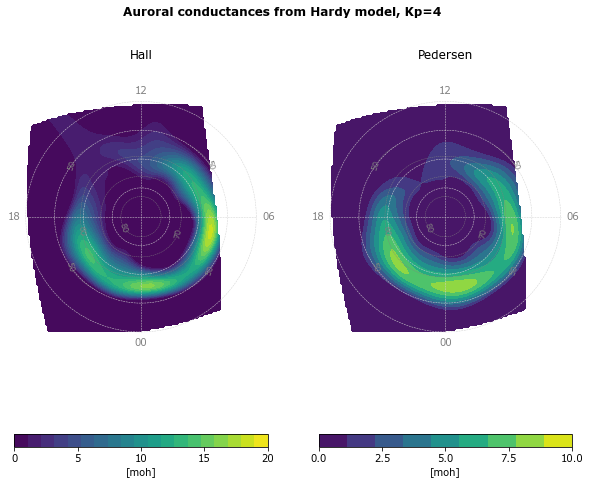

In [7]:
# Plot the conductances from Hardy
fig = plt.figure(figsize=(10,8))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

for ax in [ax1, ax2]:
    ax.axis('off')
    ax.set_aspect('equal')
    co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
    ax.clabel(co, co.levels, inline = True, fontsize = 8)

ax1.set_title('Hall')
ax2.set_title('Pedersen')

# color scales 
levels1 = np.linspace(0, 20, 20) # Hall
levels2 = np.linspace(0, 10, 10) # Pedersen



# initialize polarsubplot object:
polplot1 = lompe.model.visualization.Polarsubplot(ax1, minlat = 50, plotgrid = True, sector = 'all')
polplot1.writeMLTlabels(color='grey')
c1 = polplot1.contourf(mlat, mlt, hardy_hall.reshape(grid.shape), levels = levels1)

polplot2 = lompe.model.visualization.Polarsubplot(ax2, minlat = 50, plotgrid = True, sector = 'all')
polplot2.writeMLTlabels(color='grey')
c2 = polplot2.contourf(mlat, mlt, hardy_pedersen.reshape(grid.shape), levels = levels2)

# color bars
cbar1 = fig.colorbar(c1, ax = ax1, orientation = 'horizontal', label = '[moh]')
cbar1.set_ticks(np.linspace(0, 20, 5))
cbar2 = fig.colorbar(c2, ax = ax2, orientation = 'horizontal', label = '[moh]')
cbar2.set_ticks(np.linspace(0, 10, 5))

fig.suptitle("""Auroral conductances from Hardy model, Kp=4 \n\n""", fontweight="bold");

### EUV conductances

If we want only the EUV contribution to the conductance, we use the EUV_conductance() method directly. This method is based on a modified version of the empirical model from [Moen & Brekke (1993)](https://doi.org/10.1029/92GL02109) where $cos\chi$ is replaced with a function $q'(\chi)$ that specifies the relative maximum production due to solar EUV assuming a radially stratified atmosphere. $\chi$ is the solar zenith angle. A file containing $q'(\chi)$ for all $\chi$ between 0$^\circ$ and 120$^\circ$ (0.1$^\circ$ resolution) stored in the /data/ folder is used for the calculations. With *calibration='Cousinsetal2015'*, a modified version of the emprical conductance model from [Cousins et al. 2015](https://doi.org/10.1002/2014JA020463) is used to calculate the conductances.

To get only solar EUV contribution to the ionospheric conductance:

In [8]:
# get sza for locations from Lompe utils
sza = sunlight.sza(grid.lat, grid.lon, time)

EUV_SH, EUV_SP = EUV_conductance(sza, F107, 'hp') # or one or the other using hallOrped ('h' or 'p')

### Example to look at differences in 'calibration'

Different empirical models for the EUV conductance exist, and which *calibration* that is the best can be hard to determine. This has been pointed out by, e.g., [Ieda et al. 2014](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JA020665)) and D. Weimer in a talk titled [Unsolved Problems In Ionospheric Conductivity](http://spacescience.org/workshops/unsolvedproblems2015/presentations/dan_weimer.pdf) held in 2015. Therefore we include at least two alternative empirical models (*calibrations*) in our implementation.

We can compare the different empirical models:

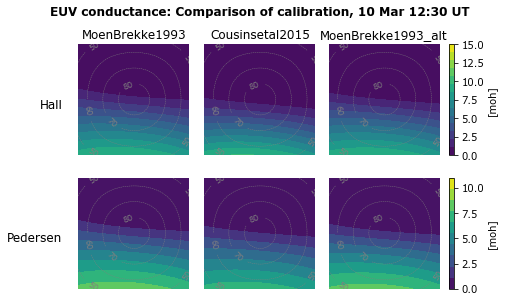

In [11]:
# using the empirical model from Cousins et al. (2015)
SH_C, SP_C = EUV_conductance(sza, F107, 'hp', calibration = 'Cousinsetal2015')
# using the empirical model from Moen & Brekke (1993) but with alternative calibration
SH_alt, SP_alt = EUV_conductance(sza, F107, 'hp', calibration = 'MoenBrekke1993_alt')

# Plot the EUV conductances for different calibrations
fig = plt.figure()
ax1, ax2, ax3, ax4, ax5, ax6 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233), fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.axis('off')
    ax.set_aspect('equal')
    co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
    ax.clabel(co, co.levels, inline = True, fontsize = 8)

# color scales 
levels1 = np.linspace(0, 15, 15) # Hall
levels2 = np.linspace(0, 11, 11) # Pedersen

# plot Hall conductances from different calibrations
ax1.contourf(grid.xi, grid.eta, EUV_SH.reshape(grid.shape), levels = levels1)
ax2.contourf(grid.xi, grid.eta, SH_C.reshape(grid.shape), levels = levels1)
c1 = ax3.contourf(grid.xi, grid.eta, SH_alt.reshape(grid.shape), levels = levels1)

ax1.text(-0.8, -0.1, 'Hall', fontsize = 12, ha = 'right')
ax1.set_title('MoenBrekke1993')
ax2.set_title('Cousinsetal2015')
ax3.set_title('MoenBrekke1993_alt')

# color bar Hall
cbar1 = fig.colorbar(c1, ax=ax3,orientation='vertical', label = '[moh]')
cbar1.set_ticks([0, 2.5, 5, 7.5, 10, 12.5, 15])

# plot Pedersen conductances from different calibrations
ax4.contourf(grid.xi, grid.eta, EUV_SP.reshape(grid.shape), levels = levels2)
ax5.contourf(grid.xi, grid.eta, SP_C.reshape(grid.shape), levels = levels2)
c2 = ax6.contourf(grid.xi, grid.eta, SP_alt.reshape(grid.shape), levels = levels2)

ax4.text(-0.8, -0.1, 'Pedersen', fontsize = 12, ha = 'right')

# color bar Pedersen
cbar2 = fig.colorbar(c2, ax = ax6, orientation = 'vertical', label = '[moh]')
cbar2.set_ticks([0, 2.5, 5, 7.5, 10])

fig.suptitle("""EUV conductance: Comparison of calibration, """+time.strftime("%d %b %H:%M UT")+"""\n\n""", fontweight="bold")

plt.subplots_adjust(hspace = 0.2, wspace = -.3, left = 0, right = 1, bottom = 0 ,top = .85);

Note that these plots are in cubed sphere $\xi$, $\eta$ coordinates, and that the grey concentric circles are geographic latitudes.